# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_mag"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 1337,
    "seed": 1337,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run2_20', 'ORACLE.run2_32', 'ORACLE.run2_26', 'ORACLE.run2_14', 'ORACLE.run2_44', 'ORACLE.run2_8', 'ORACLE.run2_50', 'ORACLE.run2_38'}


{'ORACLE.run1_8', 'ORACLE.run1_50', 'ORACLE.run1_32', 'ORACLE.run1_38', 'ORACLE.run1_44', 'ORACLE.run1_14', 'ORACLE.run1_26', 'ORACLE.run1_20'}


tensor([[[ 0.9296,  0.0939, -1.0517,  ...,  0.2911,  1.4179,  0.1502],
         [ 0.3944,  1.1831, -0.4789,  ..., -0.9578, -0.0751, -1.0610]],

        [[ 0.9965,  0.3760, -1.1469,  ..., -0.2538,  1.2410, -0.3666],
         [ 0.0564,  1.0153, -0.1034,  ..., -1.2316, -0.6769, -1.0247]],

        [[ 0.2116,  1.1347, -0.5866,  ..., -1.2694,  0.7597,  0.2308],
         [-0.5770,  0.4135,  0.7309,  ..., -0.5385, -1.1155, -0.9328]],

        ...,

        [[ 0.0523, -1.2806,  0.2417,  ...,  1.2283, -0.3332,  0.0849],
         [ 0.6729, -0.0719, -0.8167,  ...,  0.0000,  1.3132,  1.0258]],

        [[ 0.7392, -0.5706, -0.9337,  ...,  1.1152,  0.9207, -0.3825],
         [ 0.9596,  0.4409, -1.0115,  ..., -0.5511, -0.3890, -1.2903]],

        [[ 0.3781, -0.7040, -0.4367,  ...,  1.1081,  1.1473,  0.7301],
         [ 1.0821,  0.5150, -1.2907,  ..., -0.3259,  0.7040, -1.0821]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 32.8377, train_label_loss: 2.7303, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 2972.6581, train_label_loss: 0.7059, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3004.2387, train_label_loss: 0.5059, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2924.4518, train_label_loss: 0.5016, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2869.6885, train_label_loss: 0.8305, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2299.6485, train_label_loss: 0.8049, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2298.9101, train_label_loss: 0.4389, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2281.2346, train_label_loss: 0.3914, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2300.7623, train_label_loss: 0.3085, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2277.0666, train_label_loss: 0.6171, 


epoch: 1, source_val_acc_label: 0.6420, target_val_acc_label: 0.6381, source_val_label_loss: 64.1830, target_val_label_loss: 71.8609, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 2.1912, train_label_loss: 240.9635, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2324.4688, train_label_loss: 0.4996, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2584.5772, train_label_loss: 0.4402, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2638.9696, train_label_loss: 0.4520, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2693.7546, train_label_loss: 0.5293, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2333.0778, train_label_loss: 0.7630, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2330.7591, train_label_loss: 0.8401, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2302.1446, train_label_loss: 0.5479, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2326.9575, train_label_loss: 1.3325, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2309.3667, train_label_loss: 0.4892, 


epoch: 2, source_val_acc_label: 0.8229, target_val_acc_label: 0.8212, source_val_label_loss: 0.5068, target_val_label_loss: 0.4983, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.1946, train_label_loss: 0.6081, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2611.2621, train_label_loss: 0.3485, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 2847.1079, train_label_loss: 0.1946, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2957.5150, train_label_loss: 0.4492, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2955.0145, train_label_loss: 0.3531, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2603.4969, train_label_loss: 0.7799, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2603.7824, train_label_loss: 0.7735, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2613.9434, train_label_loss: 0.2470, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2600.3544, train_label_loss: 0.3104, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 2600.0991, train_label_loss: 0.1933, 


epoch: 3, source_val_acc_label: 0.8444, target_val_acc_label: 0.8418, source_val_label_loss: 0.4357, target_val_label_loss: 0.4399, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.7620, train_label_loss: 0.1185, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 2969.5990, train_label_loss: 0.1691, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3351.7106, train_label_loss: 0.8475, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3381.7998, train_label_loss: 0.5792, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3476.7676, train_label_loss: 0.1927, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 3060.3016, train_label_loss: 0.1094, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2962.0287, train_label_loss: 0.6094, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2494.5260, train_label_loss: 0.3351, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2302.4717, train_label_loss: 0.3894, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2289.5790, train_label_loss: 0.4565, 


epoch: 4, source_val_acc_label: 0.8329, target_val_acc_label: 0.8233, source_val_label_loss: 0.4561, target_val_label_loss: 0.4865, 


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.1907, train_label_loss: 0.2784, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2598.5616, train_label_loss: 0.1050, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2898.2233, train_label_loss: 0.4434, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2980.6225, train_label_loss: 0.4316, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3045.5071, train_label_loss: 0.3022, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3189.2242, train_label_loss: 0.1983, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3327.5930, train_label_loss: 0.4143, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2543.2852, train_label_loss: 0.1006, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2314.8087, train_label_loss: 0.6862, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2315.7843, train_label_loss: 0.3496, 


epoch: 5, source_val_acc_label: 0.8714, target_val_acc_label: 0.8596, source_val_label_loss: 0.3567, target_val_label_loss: 0.3890, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.0240, train_label_loss: 0.2578, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2320.3578, train_label_loss: 0.5377, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2600.5940, train_label_loss: 0.3076, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2592.9565, train_label_loss: 0.2469, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2621.3839, train_label_loss: 0.5629, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2917.9402, train_label_loss: 0.3849, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2922.5283, train_label_loss: 0.3651, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2909.8330, train_label_loss: 0.1986, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 2616.4915, train_label_loss: 0.0946, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2636.2521, train_label_loss: 0.1074, 


epoch: 6, source_val_acc_label: 0.8771, target_val_acc_label: 0.8659, source_val_label_loss: 0.3443, target_val_label_loss: 0.3821, 


New best


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.2946, train_label_loss: 0.2374, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2961.4243, train_label_loss: 0.4927, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2981.6392, train_label_loss: 0.1794, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 3005.1339, train_label_loss: 0.1310, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2977.6192, train_label_loss: 0.3099, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 3255.1915, train_label_loss: 0.3472, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 3396.6525, train_label_loss: 0.1629, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 3467.0178, train_label_loss: 0.3134, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2929.9311, train_label_loss: 0.0850, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2825.9801, train_label_loss: 0.1401, 


epoch: 7, source_val_acc_label: 0.8774, target_val_acc_label: 0.8663, source_val_label_loss: 0.3430, target_val_label_loss: 0.3858, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.0042, train_label_loss: 0.4939, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2308.3651, train_label_loss: 0.4668, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2330.0582, train_label_loss: 0.8947, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2315.9677, train_label_loss: 0.3678, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2296.2267, train_label_loss: 0.0773, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2572.8811, train_label_loss: 0.3519, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2598.6024, train_label_loss: 0.5646, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2984.9984, train_label_loss: 0.2853, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2569.3685, train_label_loss: 0.0283, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2545.1511, train_label_loss: 0.1074, 


epoch: 8, source_val_acc_label: 0.8873, target_val_acc_label: 0.8743, source_val_label_loss: 0.3079, target_val_label_loss: 0.3556, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.0087, train_label_loss: 0.1932, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2304.1500, train_label_loss: 0.1226, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 2287.7261, train_label_loss: 0.2333, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2333.4003, train_label_loss: 0.0577, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2315.0505, train_label_loss: 0.0747, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2497.4108, train_label_loss: 0.3315, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 3013.8240, train_label_loss: 0.5560, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 3286.9640, train_label_loss: 0.0599, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 3253.9224, train_label_loss: 0.0311, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3184.6835, train_label_loss: 0.0791, 


epoch: 9, source_val_acc_label: 0.8889, target_val_acc_label: 0.8700, source_val_label_loss: 0.3079, target_val_label_loss: 0.3750, 


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.7527, train_label_loss: 0.8391, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 3261.4142, train_label_loss: 0.0901, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2574.0363, train_label_loss: 0.2126, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2640.3720, train_label_loss: 0.1954, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2911.5472, train_label_loss: 0.1992, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2994.1486, train_label_loss: 0.1596, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3021.3663, train_label_loss: 0.3545, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3390.4080, train_label_loss: 0.2951, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3423.0551, train_label_loss: 0.2382, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3163.4859, train_label_loss: 0.0915, 


epoch: 10, source_val_acc_label: 0.8830, target_val_acc_label: 0.8627, source_val_label_loss: 0.3249, target_val_label_loss: 0.3875, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.7672, train_label_loss: 0.1983, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2519.7626, train_label_loss: 0.1403, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2337.6499, train_label_loss: 0.1628, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2351.7365, train_label_loss: 0.2372, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2318.3757, train_label_loss: 0.3283, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2321.2408, train_label_loss: 0.1457, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2356.7552, train_label_loss: 0.0569, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2575.8790, train_label_loss: 0.0481, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2559.8812, train_label_loss: 0.0216, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2518.7747, train_label_loss: 0.0841, 


epoch: 11, source_val_acc_label: 0.9003, target_val_acc_label: 0.8798, source_val_label_loss: 0.2766, target_val_label_loss: 0.3484, 


New best


epoch: 12, [batch: 1 / 6720], examples_per_second: 2.1756, train_label_loss: 0.4124, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2590.5086, train_label_loss: 0.2115, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 2322.5018, train_label_loss: 0.2066, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2325.7594, train_label_loss: 0.3807, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2307.7896, train_label_loss: 0.1012, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 2302.5441, train_label_loss: 0.1139, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 2391.4001, train_label_loss: 0.0304, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2568.8480, train_label_loss: 0.0909, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2604.6132, train_label_loss: 0.1160, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2525.9442, train_label_loss: 0.0917, 


epoch: 12, source_val_acc_label: 0.9044, target_val_acc_label: 0.8835, source_val_label_loss: 0.2806, target_val_label_loss: 0.3435, 


New best


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.1464, train_label_loss: 0.0692, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 2662.9723, train_label_loss: 0.0981, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2313.4790, train_label_loss: 0.3727, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2283.4555, train_label_loss: 0.0815, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2324.4377, train_label_loss: 0.1073, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2351.1297, train_label_loss: 0.0345, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2392.2993, train_label_loss: 0.1487, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2609.1767, train_label_loss: 0.0424, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 2617.3430, train_label_loss: 0.0653, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 2477.0465, train_label_loss: 0.1888, 


epoch: 13, source_val_acc_label: 0.8958, target_val_acc_label: 0.8777, source_val_label_loss: 0.2896, target_val_label_loss: 0.3544, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.1005, train_label_loss: 0.1783, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3005.2337, train_label_loss: 0.1676, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 2653.8198, train_label_loss: 0.0819, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 2608.5501, train_label_loss: 0.0517, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 2593.4477, train_label_loss: 0.1013, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 2577.2816, train_label_loss: 0.2283, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 2675.3724, train_label_loss: 0.2763, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3011.6806, train_label_loss: 0.0829, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3161.3043, train_label_loss: 0.0199, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3151.5347, train_label_loss: 0.2623, 


epoch: 14, source_val_acc_label: 0.9053, target_val_acc_label: 0.8848, source_val_label_loss: 0.2720, target_val_label_loss: 0.3400, 


New best


epoch: 15, [batch: 1 / 6720], examples_per_second: 2.1048, train_label_loss: 0.1033, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 2654.6419, train_label_loss: 0.1180, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 2404.7982, train_label_loss: 0.1807, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 2316.3496, train_label_loss: 0.0725, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2312.0558, train_label_loss: 0.1683, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2311.9981, train_label_loss: 0.0594, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2498.2545, train_label_loss: 0.3002, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2587.0492, train_label_loss: 0.1952, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2671.3088, train_label_loss: 0.0235, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2312.9621, train_label_loss: 0.0377, 


epoch: 15, source_val_acc_label: 0.9040, target_val_acc_label: 0.8845, source_val_label_loss: 0.2932, target_val_label_loss: 0.3428, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.0756, train_label_loss: 0.1947, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 2613.3307, train_label_loss: 0.1358, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 2631.6505, train_label_loss: 0.0722, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 2589.8126, train_label_loss: 0.1114, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 2620.8461, train_label_loss: 0.2105, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 2579.2672, train_label_loss: 0.2138, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 2865.5256, train_label_loss: 0.4418, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 3012.0383, train_label_loss: 0.1012, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3026.5604, train_label_loss: 0.4388, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 2583.8978, train_label_loss: 0.0228, 


epoch: 16, source_val_acc_label: 0.9015, target_val_acc_label: 0.8752, source_val_label_loss: 0.2876, target_val_label_loss: 0.3624, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 2.5401, train_label_loss: 0.2283, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 3000.7312, train_label_loss: 0.0509, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 3066.6665, train_label_loss: 0.0680, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 3098.4496, train_label_loss: 0.3557, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 2965.6168, train_label_loss: 0.0725, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 2922.5839, train_label_loss: 0.3270, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 2640.1248, train_label_loss: 0.1260, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 2589.4378, train_label_loss: 0.0776, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 2674.5006, train_label_loss: 0.0845, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 2294.4176, train_label_loss: 0.4034, 


epoch: 17, source_val_acc_label: 0.9067, target_val_acc_label: 0.8845, source_val_label_loss: 0.3159, target_val_label_loss: 0.3562, 


epoch: 18, [batch: 1 / 6720], examples_per_second: 2.0087, train_label_loss: 0.3801, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 2316.3477, train_label_loss: 0.0556, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 2325.9363, train_label_loss: 0.0785, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 2399.4572, train_label_loss: 0.1666, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 2603.3739, train_label_loss: 0.1795, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 2548.4730, train_label_loss: 0.1005, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 2757.5487, train_label_loss: 0.1822, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 2627.5843, train_label_loss: 0.0789, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 2658.3779, train_label_loss: 0.1970, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 2480.3964, train_label_loss: 0.2543, 


epoch: 18, source_val_acc_label: 0.9043, target_val_acc_label: 0.8813, source_val_label_loss: 0.2893, target_val_label_loss: 0.3616, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

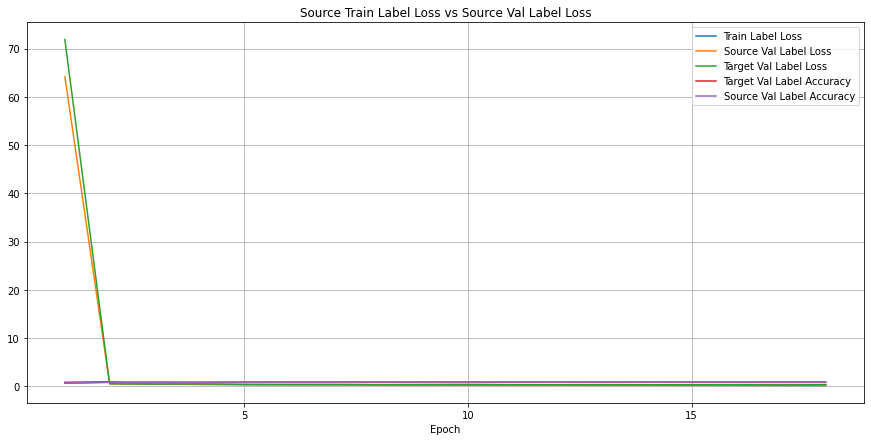

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

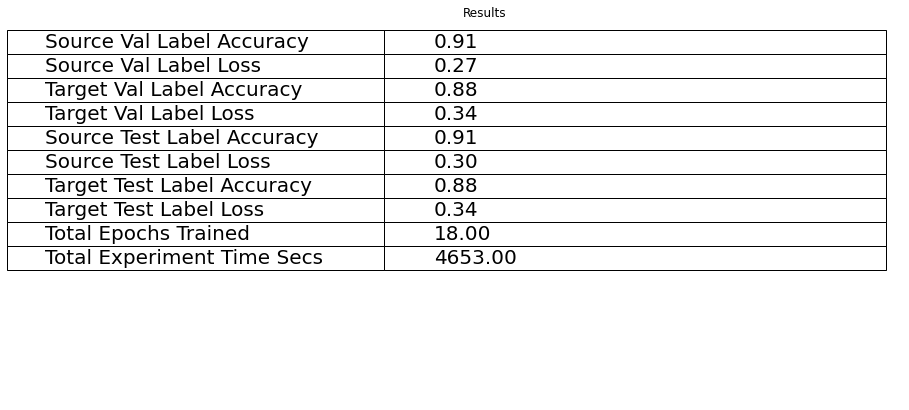

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

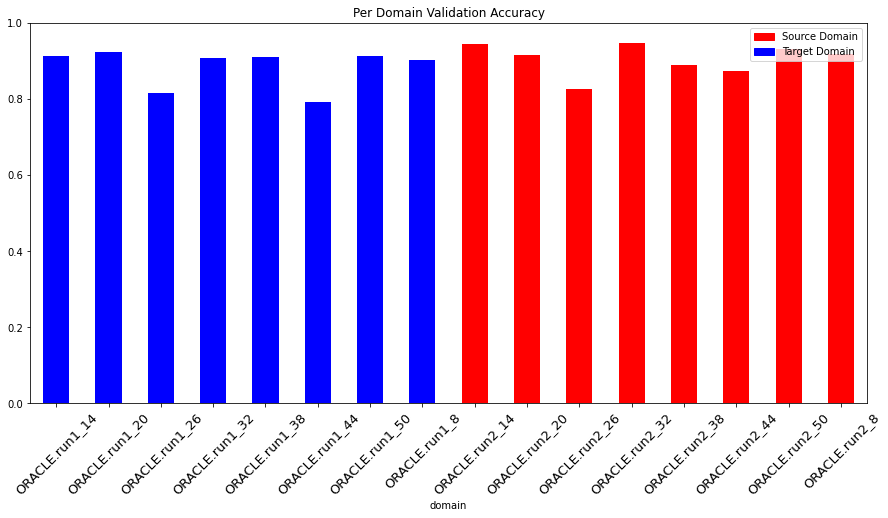

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9058268229166667 Target Test Label Accuracy: 0.883984375
Source Val Label Accuracy: 0.9053385416666667 Target Val Label Accuracy: 0.884765625


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048